In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table, join, QTable, vstack
import astropy.units as u
import sys
import pyneb as pn
from multiprocessing import Pool
import multiprocessing as mp
import math
from astropy.io import fits
from orcs.process import SpectralCube

from astropy.nddata import NDData, Cutout2D
from astropy.wcs import WCS

import astropy.units as u
from astropy.coordinates import SkyCoord

from reproject import reproject_interp
from regions import PixCoord

import pylab as pl

from scipy.optimize import curve_fit
from scipy.integrate import quad

from orb.fit import fit_lines_in_spectrum
from orb.utils.spectrum import corr2theta, amp_ratio_from_flux_ratio
from orb.core import Lines
import gvar
import orb

import extinction
from extinction import apply, remove

INFO:numexpr.utils:Note: NumExpr detected 64 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


### Import catalogs

In [35]:
galaxynum = 5
galdic = {1:'NGC4254', 2:'NGC4535', 3:'NGC3351', 4:'NGC2835', 5:'NGC0628'}  #There is no SITELLE data for NGC 4254, NGC 2835 has the best data 
galaxy = galdic[galaxynum]
print(galaxy)

infile = open(f"/home/habjan/jupfiles/data/{galaxy}_physdata_MUSE+SITELLE.fits",'rb')
physdata = Table.read(infile)

infile = open(f"/home/habjan/jupfiles/data/{galaxy}_refit+SITELLEfits_data.fits",'rb')
data = Table.read(infile)

hdul = fits.open(f"/home/habjan/jupfiles/data/SIGNALS_Catalog/NGC628_catalog.fits")
signals = hdul[0].data             #This is just a numpy array, use the text file to see what each index of the array is. There are 4284 HII regions in total

NGC0628


### Here are indices of interst in the SIGNALS catalog

catalog[0:,1] : Right ascension

catalog[0:,2] : Declination

catalog[0:,3] : Galactocentric radius

catalog[0:,13] : EBV; extinction;  E(B-V)

catalog[0:,14] : EBV_err; extinction error; E(B-V) error

catalog[0:,24] : log [OIII]5007/Hb ; log line ratio

catalog[0:,25] : error on log [OIII]5007/Hb ; log line ratio error

catalog[0:,26] : SNR_cross on [OIII]5007/Hb; line ratio best SNR  

catalog[0:,27] : log [OII]3727/Hb ; log line ratio 

catalog[0:,28] : error on log [OII]3727/Hb ; log line ratio error 

catalog[0:,29] : SNR_cross on [OII]3727/Hb; line ratio best SNR   

catalog[0:,30] : log ([OII]3727+[OII]5007)/Hb ; log line ratio  

catalog[0:,31] : error on log ([OII]3727+[OII]5007)/Hb ; log line ratio error

catalog[0:,32] : SNR_cross on ([OII]3727+[OII]5007)/Hb; line ratio best SNR 

catalog[0:,33] : log [OIII]5007/[OII]3727 ; log line ratio 

catalog[0:,34] : error on log [OIII]5007/[OII]3727 ; log line ratio error

catalog[0:,35] : SNR_cross on [OIII]5007/[OII]3727; line ratio best SNR

### Compare distributions of log( [OIII]5007/H $\beta$ )

/home/habjan/.conda/envs/orb3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log10
  """Entry point for launching an IPython kernel.


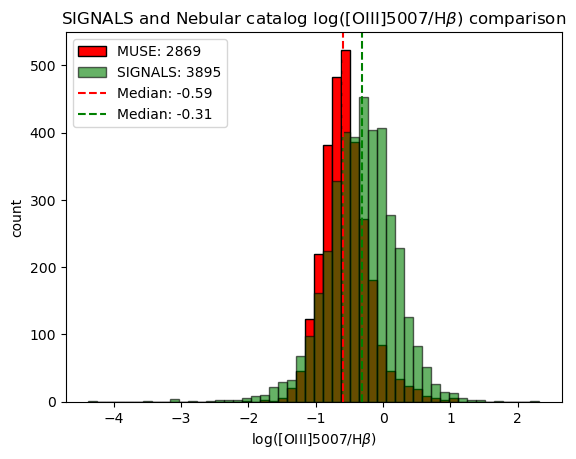

In [9]:
logoiiihb = np.log10(data['OIII5006_FLUX_CORR']/data['HB4861_FLUX_CORR'])
sigoiiihb = np.array([signals[i][24] for i in range(len(signals)) if ~np.isnan(signals[i][24])])

a=np.random.random(100)*0.5 #a uniform distribution
b=1-np.random.normal(size=100)*0.1 #a normal distribution 
bins=np.histogram(np.hstack((logoiiihb,sigoiiihb)), bins=50)[1] #get the bin edges

plt.hist(logoiiihb, edgecolor = 'k', color='red', alpha = 1, bins=bins, label = f'MUSE: {len(logoiiihb)}');
plt.hist(sigoiiihb, color='green', edgecolor='k', alpha = 0.6, bins=bins, label = f'SIGNALS: {len(sigoiiihb)}');
plt.axvline(np.median(logoiiihb), color='red', linestyle='--', label = f'Median: {round(np.median(logoiiihb), 2)}')
plt.axvline(np.median(sigoiiihb), color='green', linestyle='--', label = f'Median: {round(np.median(sigoiiihb), 2)}')

plt.title(r'SIGNALS and Nebular catalog log([OIII]5007/H$\beta$) comparison')
plt.xlabel(r'log([OIII]5007/H$\beta$)')
plt.ylabel('count')
plt.legend(loc='upper left')

### Compare distributions of log( [OIII]5007 / [OII]3727)

/home/habjan/.conda/envs/orb3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.
/home/habjan/.conda/envs/orb3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.
/home/habjan/.conda/envs/orb3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Warning: converting a masked element to nan.
  """Entry point for launching an IPython kernel.


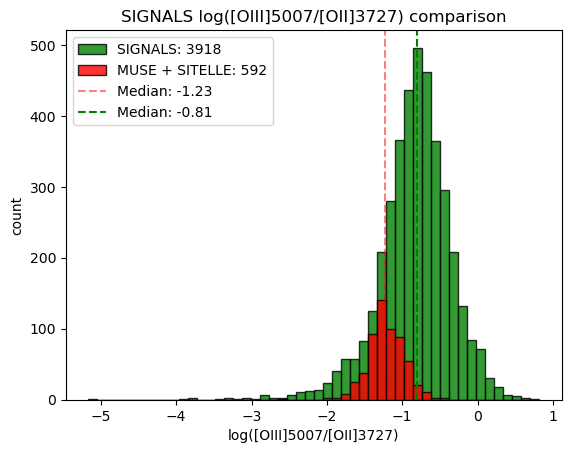

In [11]:
logoiiioii = np.array([data[i]['OIII5006_FLUX_CORR']/(data[i]['OII3726_FLUX_CORR'] + data[i]['OII3729_FLUX_CORR'])[0] for i in range(len(data))])
logoiiioii = logoiiioii[np.where(~np.isnan(logoiiioii))]
logoiiioii = np.log10(logoiiioii)
sigoiiioii = np.array([signals[i][33] for i in range(len(signals)) if ~np.isnan(signals[i][33])])
sigoiiioii[sigoiiioii > 10**40] = 0

a=np.random.random(100)*0.5 #a uniform distribution
b=1-np.random.normal(size=100)*0.1 #a normal distribution 
bins=np.histogram(np.hstack((logoiiioii,sigoiiioii)), bins=50)[1] #get the bin edges

plt.hist(sigoiiioii, color='green', edgecolor='k', alpha = 0.8, bins=bins, label = f'SIGNALS: {len(sigoiiioii)}');
plt.hist(logoiiioii, color='red', edgecolor='k', alpha = 0.8, bins=bins, label = f'MUSE + SITELLE: {len(logoiiioii)}');
plt.axvline(np.median(logoiiioii), color='red', alpha=0.5, linestyle='--', label = f'Median: {round(np.median(logoiiioii), 2)}')
plt.axvline(np.median(sigoiiioii), color='green', linestyle='--', label = f'Median: {round(np.median(sigoiiioii), 2)}')

plt.title(r'SIGNALS log([OIII]5007/[OII]3727) comparison')
plt.xlabel(r'log([OIII]5007/[OII]3727)')
plt.ylabel('count')
plt.legend(loc='upper left')

### Match SIGNALS and MUSE regions with celestial coordinates

catalog[0:,1] : Right ascension

catalog[0:,2] : Declination

catalog[0:,3] : Galactocentric radius

In [13]:
rval = 2
siglist = []
mylist = []
count = 0

signalsdic = {'cen_ra': 1, 'cen_dec': 2, 'radius': 3}

distdic = {'NGC4254': 13.1 , 'NGC4535': 16.60  , 'NGC3351': 10.0, 'NGC2835': 10.4, 'NGC0628':7.5}
dist = distdic[galaxy]
kpc = data['deproj_dist'] / 206265 * (dist * 1000)
nkpc = np.array([kpc[i] for i in range(len(kpc))])

for j in range(len(data)):
    for i in range(len(signals)):
        if round(signals[i][signalsdic['cen_dec']], rval) == round(data[j]['cen_dec'], rval) and round(signals[i][signalsdic['cen_ra']], rval) == round(data[j]['cen_ra'], rval):# and round(nkpc[j], rval) == round(signals[i][signalsdic['radius']], rval):
            count += 1
            siglist.append(i)
            mylist.append(j)
    if count > 1:
        print(count, i)
    count = 0

len(siglist), len(mylist)

33 4284
20 4284
39 4284
34 4284
54 4284
39 4284
39 4284
64 4284
39 4284
51 4284
54 4284
45 4284
25 4284
39 4284
20 4284
47 4284
39 4284
20 4284
47 4284
45 4284
39 4284
40 4284
42 4284
48 4284
34 4284
67 4284
42 4284
43 4284
42 4284
48 4284
41 4284
55 4284
47 4284
33 4284
48 4284
51 4284
52 4284
14 4284
42 4284
64 4284
41 4284
47 4284
51 4284
20 4284
64 4284
67 4284
14 4284
64 4284
64 4284
41 4284
41 4284
54 4284
50 4284
34 4284
39 4284
47 4284
41 4284
41 4284
32 4284
51 4284
55 4284
32 4284
43 4284
34 4284
45 4284
39 4284
34 4284
48 4284
82 4284
20 4284
47 4284
42 4284
72 4284
40 4284
39 4284
52 4284
20 4284
33 4284
39 4284
67 4284
42 4284
54 4284
32 4284
39 4284
52 4284
54 4284
42 4284
67 4284
54 4284
72 4284
45 4284
48 4284
42 4284
41 4284
20 4284
48 4284
30 4284
47 4284
30 4284
41 4284
82 4284
39 4284
48 4284
55 4284
47 4284
42 4284
41 4284
50 4284
64 4284
39 4284
82 4284
54 4284
52 4284
50 4284
48 4284
47 4284
45 4284
52 4284
34 4284
50 4284
43 4284
82 4284
39 4284
54 4284
50 4284


(140319, 140319)

### Plot the matched regions

In [15]:
logoiiioiinan = np.array([data[i]['OIII5006_FLUX_CORR']/(data[i]['OII3726_FLUX_CORR'] + data[i]['OII3729_FLUX_CORR'])[0] for i in mylist])
logoiiioii = logoiiioiinan[np.where(~np.isnan(logoiiioiinan))]
logoiiioii = np.log10(logoiiioii)
sigoiiioii = np.array([signals[np.array(siglist)[np.where(~np.isnan(logoiiioiinan))[0]]][i][33] for i in range(len(logoiiioii))])

plt.scatter(logoiiioii, sigoiiioii, color='red', label=f'HII Regions: {len(logoiiioii)}')

plt.plot(np.linspace(-10, 10, 10), np.linspace(-10, 10, 10), c='k', label='1-to-1 line')

plt.title(f'SIGNALS log([OIII]5007/[OII]3727) comparison in {galaxy}')
plt.xlabel('Erics log([OIII]5007/[OII]3727)')
plt.ylabel('SIGNALS log([OIII]5007/[OII]3727)')
lowb = -2.25
upb = 0.5
plt.xlim(lowb, upb)
plt.ylim(lowb, upb)
plt.legend()

/home/habjan/.conda/envs/orb3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.


KeyboardInterrupt: 

# Compare log(OIII/OII) versus log(OIII/HBeta)

### Make numpy arrays

In [29]:
museoiiioii = np.zeros(len(data))
museoiiihb = np.zeros(len(data))
museoiihb = np.zeros(len(data))
for i in range(len(data)):
    if np.isnan(data[i]['OIII5006_FLUX_CORR']/(data[i]['OII3726_FLUX_CORR'].data + data[i]['OII3729_FLUX_CORR'].data))[0] == False:
        museoiiioii[i] = np.log10(data[i]['OIII5006_FLUX_CORR']/(data[i]['OII3726_FLUX_CORR'][0] + data[i]['OII3729_FLUX_CORR'][0]))
    else: 
        museoiiioii[i] = np.nan
    if np.isnan(np.log10(data[i]['OIII5006_FLUX_CORR']/data[i]['HB4861_FLUX_CORR'])) == False:
        museoiiihb[i] = np.log10(data[i]['OIII5006_FLUX_CORR']/data[i]['HB4861_FLUX_CORR'])
    else: 
        museoiiihb[i] = np.nan
    if np.isnan((data[i]['OII3726_FLUX_CORR'].data + data[i]['OII3729_FLUX_CORR'].data)/data[i]['HB4861_FLUX_CORR'])[0] == False:
        museoiihb[i] = np.log10((data[i]['OII3726_FLUX_CORR'].data + data[i]['OII3729_FLUX_CORR'].data)/data[i]['HB4861_FLUX_CORR'])
    else: 
        museoiihb[i] = np.nan

sigoiiioii = np.array([signals[i][33] for i in range(len(signals))])
sigoiiihb = np.array([signals[i][24] for i in range(len(signals))])
sigoiihb = np.array([signals[i][27] for i in range(len(signals))])

/home/habjan/.conda/envs/orb3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log10
  if __name__ == "__main__":
/home/habjan/.conda/envs/orb3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log10
  # Remove the CWD from sys.path while we load stuff.


### Plot results

catalog[0:,24] : log [OIII]5007/Hb ; log line ratio

catalog[0:,27] : log [OII]3727/Hb ; log line ratio 

catalog[0:,33] : log [OIII]5007/[OII]3727 ; log line ratio 

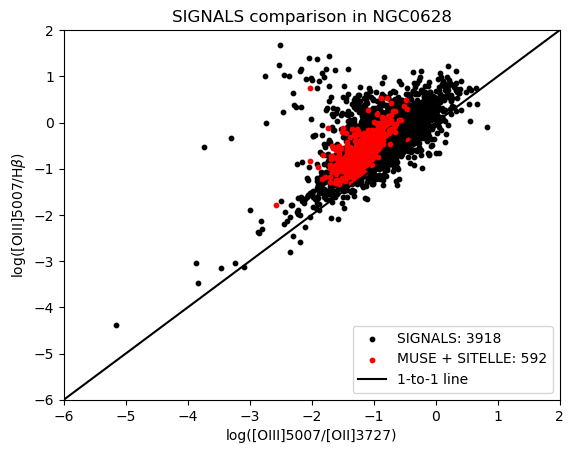

In [30]:
plt.scatter(sigoiiioii, sigoiiihb, color='k', s=10, label=f'SIGNALS: {len(np.where(~np.isnan(sigoiiioii))[0])}')
plt.scatter(museoiiioii, museoiiihb, color='red', s=10, label=f'MUSE + SITELLE: {len(np.where(~np.isnan(museoiiioii))[0])}')

plt.plot(np.linspace(-10, 10, 10), np.linspace(-10, 10, 10), c='k', label='1-to-1 line')

plt.title(f'SIGNALS comparison in {galaxy}')
plt.xlabel('log([OIII]5007/[OII]3727)')
plt.ylabel(r'log([OIII]5007/H$\beta$)')
lowb = -6
upb = 2
plt.xlim(lowb, upb)
plt.ylim(lowb, upb)
plt.legend(loc='lower right')

### MUSE+SITELLE data with color map

/home/habjan/.conda/envs/orb3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Warning: converting a masked element to nan.
  """Entry point for launching an IPython kernel.


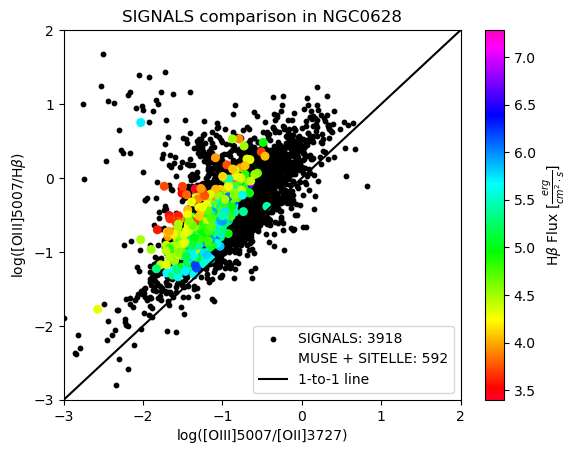

In [31]:
hbeta = np.log10(np.array([data[i]['HB4861_FLUX_CORR'] for i in range(len(data))]))

plt.scatter(sigoiiioii, sigoiiihb, color='k', s=10, label=f'SIGNALS: {len(np.where(~np.isnan(sigoiiioii))[0])}')
plt.scatter(museoiiioii, museoiiihb, c=hbeta, cmap='gist_rainbow', s=30, label=f'MUSE + SITELLE: {len(np.where(~np.isnan(museoiiioii))[0])}')

plt.plot(np.linspace(-10, 10, 10), np.linspace(-10, 10, 10), c='k', label='1-to-1 line')

plt.title(f'SIGNALS comparison in {galaxy}')
plt.xlabel('log([OIII]5007/[OII]3727)')
plt.ylabel(r'log([OIII]5007/H$\beta$)')
lowb = -3
upb = 2
plt.xlim(lowb, upb)
plt.ylim(lowb, upb)
plt.legend(loc='best')

plt.colorbar(label=r'H$\beta$ Flux [$\frac{erg}{cm^{2} \cdot s}$]')

### Plot oxygen lines only over Hbeta

/home/habjan/.conda/envs/orb3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Warning: converting a masked element to nan.
  """Entry point for launching an IPython kernel.


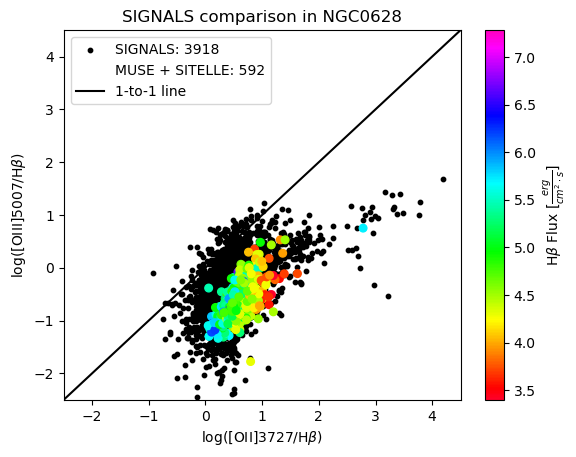

In [34]:
hbeta = np.log10(np.array([data[i]['HB4861_FLUX_CORR'] for i in range(len(data))]))

plt.scatter(sigoiihb, sigoiiihb, color='k', s=10, label=f'SIGNALS: {len(np.where(~np.isnan(sigoiiioii))[0])}')
plt.scatter(museoiihb, museoiiihb, c=hbeta, cmap='gist_rainbow', s=30, label=f'MUSE + SITELLE: {len(np.where(~np.isnan(museoiiioii))[0])}')

plt.plot(np.linspace(-10, 10, 10), np.linspace(-10, 10, 10), c='k', label='1-to-1 line')

plt.title(f'SIGNALS comparison in {galaxy}')
plt.xlabel(r'log([OII]3727/H$\beta$)')
plt.ylabel(r'log([OIII]5007/H$\beta$)')
lowb = -2.5
upb = 4.5
plt.xlim(lowb, upb)
plt.ylim(lowb, upb)
plt.legend(loc='best')

plt.colorbar(label=r'H$\beta$ Flux [$\frac{erg}{cm^{2} \cdot s}$]')

### Plot Histograms of the [OII] Fluxes

/home/habjan/.conda/envs/orb3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Warning: converting a masked element to nan.
  """Entry point for launching an IPython kernel.
/home/habjan/.conda/envs/orb3/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Warning: converting a masked element to nan.
  


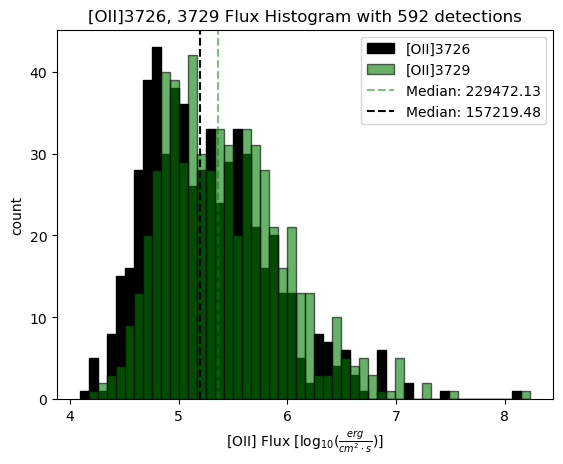

In [20]:
oii3726 = np.array([data[i]['OII3726_FLUX_CORR'] for i in range(len(data)) if ~np.isnan(float(data[i]['OII3726_FLUX_CORR'][0]))])
oii3729 = np.array([data[i]['OII3729_FLUX_CORR'] for i in range(len(data)) if ~np.isnan(float(data[i]['OII3729_FLUX_CORR'][0]))])
oii3726 = np.log10(oii3726)
oii3729 = np.log10(oii3729)
med3726 = np.median(oii3729)
med3729 = np.median(oii3726)

a=np.random.random(100)*0.5 #a uniform distribution
b=1-np.random.normal(size=100)*0.1 #a normal distribution 
bins=np.histogram(np.hstack((oii3726,oii3729)), bins=50)[1] #get the bin edges

plt.hist(oii3726, color='k', edgecolor='k', alpha = 1, bins=bins, label = f'[OII]3726');
plt.hist(oii3729, color='green', edgecolor='k', alpha = 0.6, bins=bins, label = f'[OII]3729');
plt.axvline(med3726, color='green', alpha=0.5, linestyle='--', label = f'Median: {round(10**med3726, 2)}')
plt.axvline(med3729, color='k', linestyle='--', label = f'Median: {round(10**med3729, 2)}')

plt.title(f'[OII]3726, 3729 Flux Histogram with {len(oii3726)} detections')
plt.xlabel(r'[OII] Flux [log$_{10}(\frac{erg}{cm^{2} \cdot s})$]')
#plt.xscale('log')
plt.ylabel('count')
plt.legend(loc='upper right')

### Compare uncertainties from my MC estimation and the ORCS estimation

In [37]:
err3726 = []
err3729 = []

for i in range(len(data)):
    if np.isnan(data[i]['OII3726_FLUX_CORR_ERR']/physdata[i]['OII3726_FLUX_CORR_ERR']) == False:
        err3726.append(data[i]['OII3726_FLUX_CORR_ERR']/physdata[i]['OII3726_FLUX_CORR_ERR'])
    if np.isnan(data[i]['OII3729_FLUX_CORR_ERR']/physdata[i]['OII3729_FLUX_CORR_ERR']) == False:
        err3729.append(data[i]['OII3729_FLUX_CORR_ERR']/physdata[i]['OII3729_FLUX_CORR_ERR'])
ave3726 = round(np.mean(err3726),3)
ave3729 = round(np.mean(err3729), 3)
print(f'The error ratio of mine/ORCS errors for [OII]3726 is {ave3726} and [OII]3729 is {ave3729}')

The error ratio of mine/ORCS errors for [OII]3726 is 0.498 and [OII]3729 is 0.512
